In [1]:
!wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl

--2023-04-16 17:47:29--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 18.244.202.81, 18.244.202.50, 18.244.202.77, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|18.244.202.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381624121 (364M) [binary/octet-stream]
Saving to: ‘ffhq.pkl’

ffhq.pkl            100%[===================>] 363.94M   136MB/s    in 2.7s    

2023-04-16 17:47:33 (136 MB/s) - ‘ffhq.pkl’ saved [381624121/381624121]



In [2]:
!pip install gdown
!gdown 1bTHWDchdcVpx8xN98lTcPZqm6qKw9x2Q
!gdown 1QvSinTMnNNyO3MHcgbfWpL6Z88iSL_fZ

Downloading...
From: https://drive.google.com/uc?id=1bTHWDchdcVpx8xN98lTcPZqm6qKw9x2Q
To: /kaggle/working/ica_stylegan_components.csv
100%|████████████████████████████████████████| 261k/261k [00:00<00:00, 68.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QvSinTMnNNyO3MHcgbfWpL6Z88iSL_fZ
To: /kaggle/working/ica_stylegan_components_100.csv
100%|███████████████████████████████████████| 1.31M/1.31M [00:00<00:00, 114MB/s]


In [3]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 128, done.
remote: Total 128 (delta 0), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (128/128), 1.12 MiB | 13.04 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [4]:
%cd stylegan2-ada-pytorch

/kaggle/working/stylegan2-ada-pytorch


In [5]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from PIL import Image

import numpy as np

import copy
import pickle
import os

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
with open('/kaggle/working/ffhq.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].to(device) 

In [8]:
sum(p.numel() for p in G.parameters())

30370060

In [9]:
%cd /kaggle/working

/kaggle/working


In [10]:
def gen_samples(path, G, n_samples, batch_size, device):
    n_iter = n_samples // batch_size
    for i in range(n_iter):
        z = torch.randn([batch_size, G.z_dim]).to(device)
        w = G.mapping(z, None)[:, 0]
        if os.path.exists(path):
            with open(path, "ab") as f:
                np.savetxt(f, w.detach().cpu().numpy(), delimiter=",")
        else:
            np.savetxt(path, w.detach().cpu().numpy(), delimiter=",")
    return np.loadtxt(os.path.join(path), delimiter=",")

In [11]:
from sklearn.decomposition import PCA, FastICA

In [12]:
path = "/kaggle/working/ica_stylegan_components_100.csv"
if os.path.exists(path):
    pc = np.loadtxt(path, delimiter=",")
else:
    n_samples = 100000
    batch_size = 50
    vectors = gen_samples(path, G, n_samples, batch_size, device)
    ica = FastICA(n_components=20)
    ica.fit(vectors)
    pc = ica.components_
    np.savetxt(path, pc, delimiter=",")

In [13]:
pc.shape

(100, 512)

In [17]:
z = torch.randn([5, G.z_dim]).to(device) 

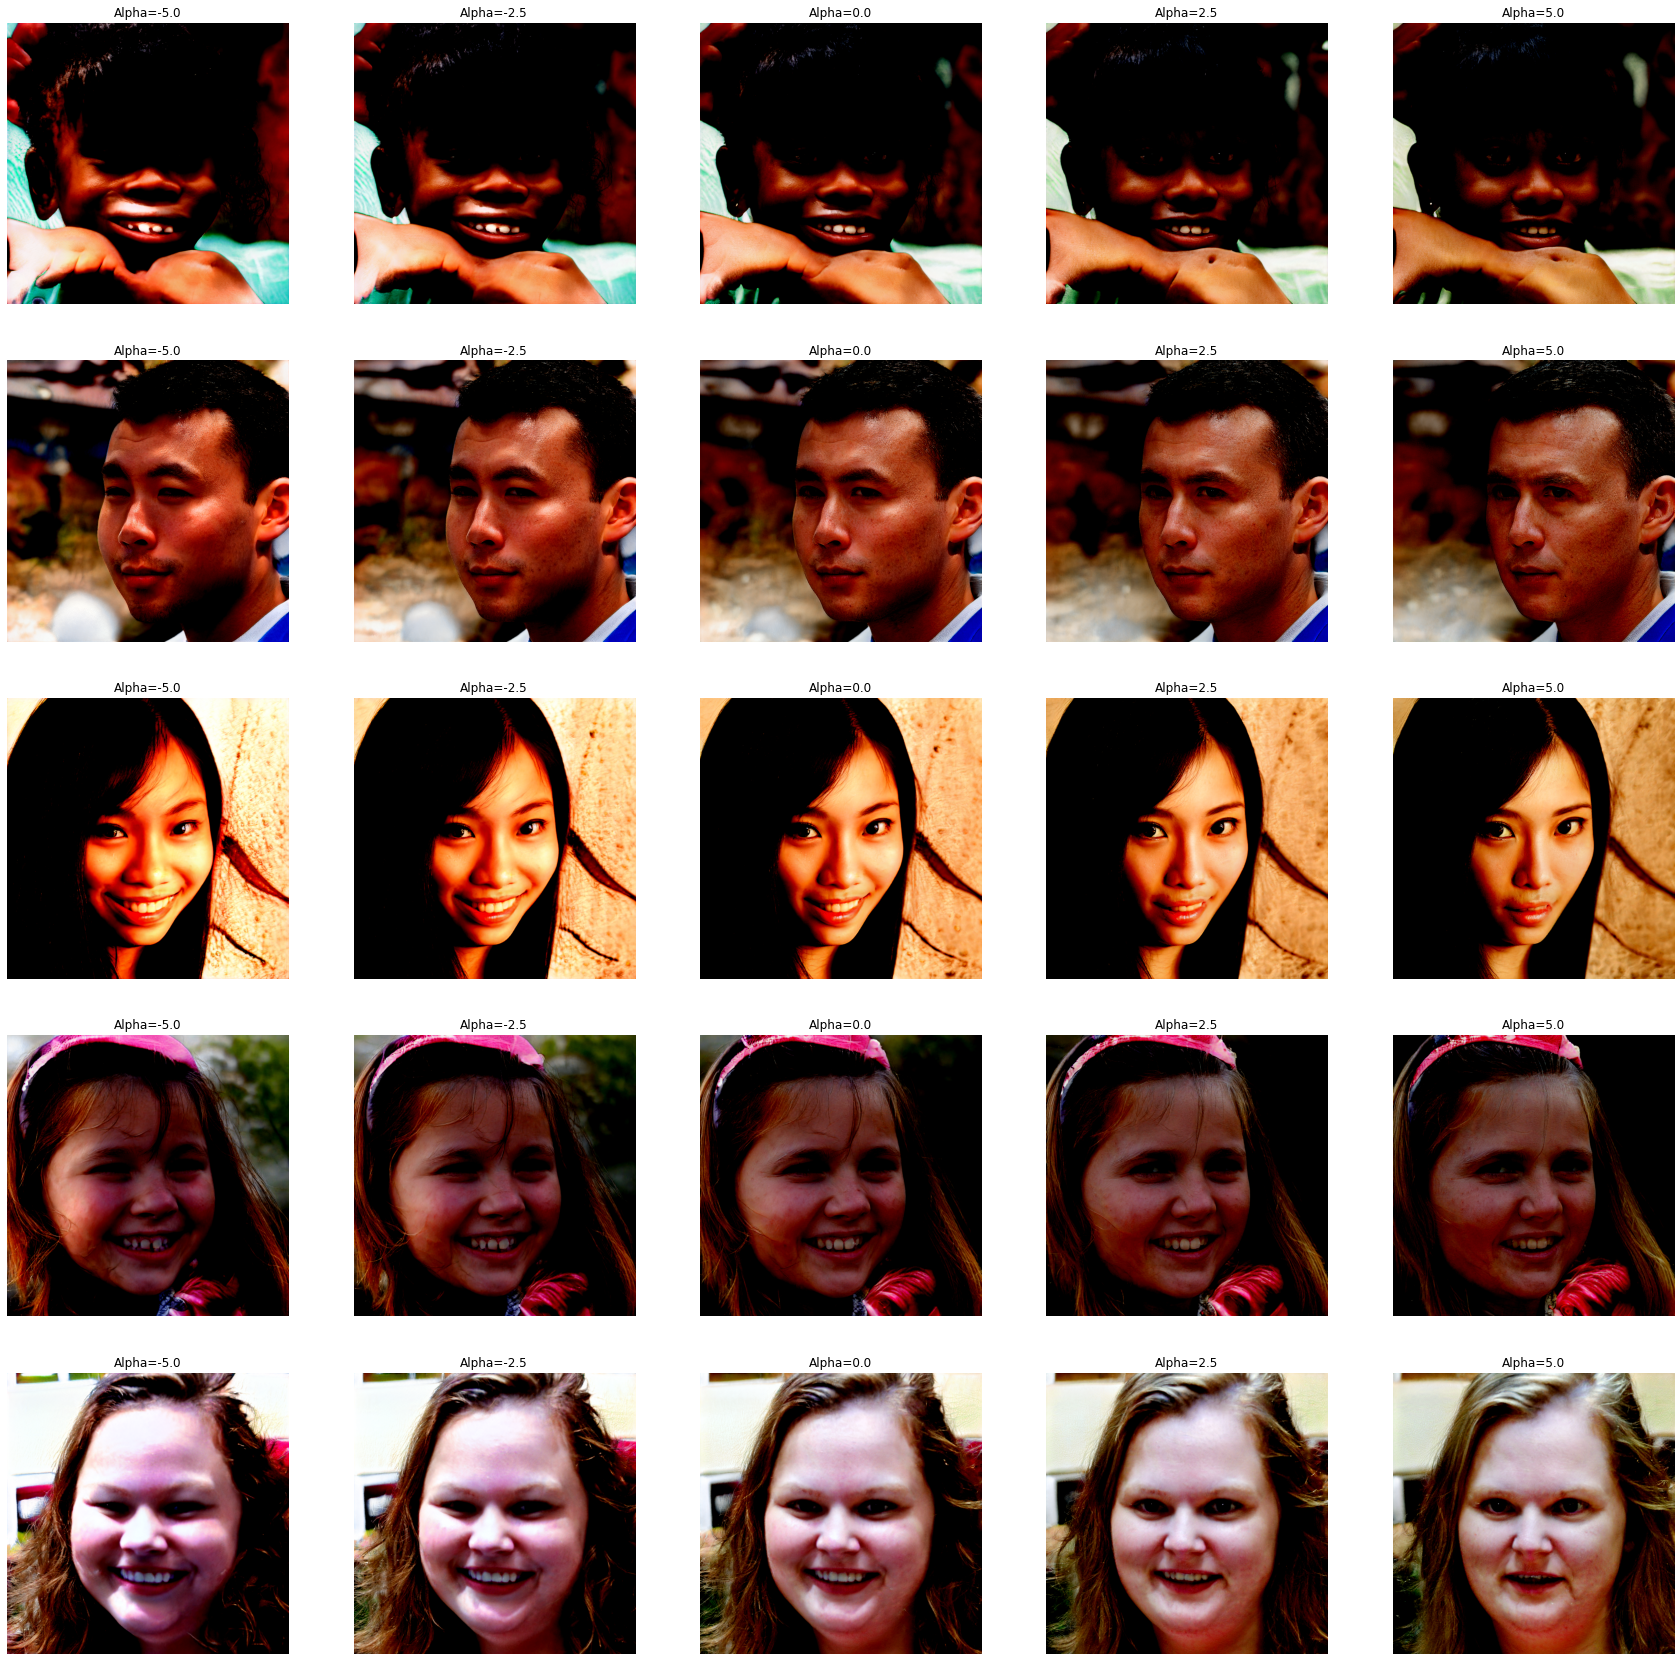

In [19]:
idx = 0
alphas = np.linspace(-5, 5, 5)
edits = torch.tensor(alphas.reshape(-1,1)*(pc[idx]/np.linalg.norm(pc[idx]))).to(device)
edits = edits.unsqueeze(1).repeat_interleave(18, dim=1)
fig, axs = plt.subplots(5,5, figsize=(30,30))

for idx in range(5):
    w = G.mapping(z[idx].unsqueeze(0), None)
    w_edits = w.repeat(5, 1, 1)
    w_edits[:, :]+=edits[:, :]
    for i, w_edit in enumerate(w_edits):
        img = G.synthesis(w_edit.unsqueeze(0))[0]
        out = img.permute([1,2,0]).detach().cpu().numpy()
        axs[idx, i].axis('off')
        axs[idx, i].imshow(out)
        axs[idx, i].set_title(f"Alpha={alphas[i]}")